# Short introduction

In this article we simulate the distribution of damage output by a character
in Dungeons and Dragons. We'll then consider the data collection requirements
to reverse-engineer the rules associated with some Homebrew DnD content by
Monte Carlo methods. We'll use PyMC for our simulation and modelling.


## Why would we do this?

If you're a fan of the Dungeons & Dragons stream [Critical Role](https://critrole.com/) or if
you've played any DnD yourself, you're aware that the rules of the game are really
what the table decides to make of them. Online communities can be particularly
strident in their defense of particular rule interpretations, and
[Munchkin's](https://en.wikipedia.org/wiki/Munchkin_(role-playing_games)) can
be especially notorious for this. A significant portion of the community takes
particular pleasure in finding ways to maximize their damage output in a single
round or over the course of an in-game day, and layer complex rule interactions
to achieve their goals.

Homebrew DnD content (community content) can show up in a lot of games, but your
average Game Master (GM) doesn't have the luxury of thousands of playtest hours 
to tune their classes. It's generally accepted that homebrew content isn't balanced
and may be over- or under-powered, so it rarely receives a lot of community
feedback. Most GM's aren't [Matt Mercer](https://en.wikipedia.org/wiki/Matthew_Mercer)
over at Critical Role, whose stream is routinely watched live by 60,000-75,000
viewers.

Matt's homebrew is typically not released to the community, which leaves
a lot of people guessing about how abilities work. Furthermore, Matt tunes his
homebrew throughout a campaign so observations of particular outcomes are
limited. Characters level up, which typically affects their core features.
Whether tuning or level-related, _when_ changes occur may also not be clear.
In other words, underlying data generating process changes with time.

Matt isn't entirely a black-box however. He answers community questions, and
with such a large community people eventually discover the mechanics behind his
homebrew features.
Let's assume that Matt _is_ a black box. We wish to figure out the mechanics
behind the ability _Chaos Burst_ of one of his player-characters, Ashton. We
have some basic rules that are safe to assume, and then other rules that we
aren't sure of. Talesin (Ashton's player) indicates what ability he is using,
is informed by Matt whether or not he is successfull, and then Talesin reports
the damage that he did. Can we look at a collection of his outcomes and find
the member of a family of models that most corresponds to the homebrew rules?


# Getting started

We'll be using seaborn to produce diagrams, and we'll be using
[`PyMC`](https://docs.pymc.io/en/v3/) to run the simulation.

In [1]:
import pymc3 as pm
from pymc3 import math as pmm
import seaborn as sns

# Simulate Combat

We are analyzing the damage output of Ashton, a level 3 barbarian whose
subclass is homebrew by Matt Mercer. Ashton has several abilities that we are
not certain of, but let's obtain a baseline for the damage output generic
third-level barbarian.  We'll define a model of damage output for a single
attack. We'll assume most character details are constant (i.e., ability scores),
and we'll use a constant armor class for the target of the attack. We'll assume
that the barbarian is raging (as they should be), that they have a versatile
weapon, and that they have the great weapon master feat.

In [2]:
RANDOM_SEED = 123423452


with pm.Model() as model:
    # These are relatively static parameters of our model. We expect that these
    # values wont' change over the course of our data collection period.
    character_strength = 17
    ability_modifier = pm.Constant(
        "Ability Modifier", (character_strength - 10) // 2)
    crit_threshold = pm.Constant("Critical Range", 20)
    proficiency_bonus = pm.Constant("Proficiency Bonus", 2)
    rage_damage = pm.Constant("Rage Damage", 2)

    # When simulating output from the model, target armor class affects the
    # frequency of the "0 damage" term. We can estimate model parameters
    # independent of armor class if all of our observations at least include
    # whether an attack hit / was critical.
    target_ac = pm.Constant("Target AC", 15)

    # These are set to the frequency at which we think that these features are
    # used. Some players will always / never use these features, and the
    # majority of players will take into account the armor class of their
    # opponent or their own need for a free hand
    using_gwm = pm.Bernoulli("Using GWM", 0.5)
    using_versatile = pm.Bernoulli("Using Versatile", 0.75)
    
    # An attack hits the attack score is at least as large as the target's
    # armor class, or if the attack is a critical. A critical hit occurs if
    # the attack role is at least as large as the critical range / threshold
    # of the attacker. A critical hit is still a hit even if the target's
    # armor class wouldn't normally allow for it.
    attack_roll = pm.DiscreteUniform("Attack Roll", 1, 20)
    attack = pm.Deterministic("Attack",
        attack_roll + ability_modifier + proficiency_bonus
        - pmm.switch(using_gwm, 5, 0))

    normal_hit = pm.Deterministic("Normal Hit", pmm.ge(attack, target_ac))
    critical_hit = pm.Deterministic(
        "Critical Hit", pmm.ge(attack_roll, crit_threshold))
    any_hit = pm.Deterministic("Hit", pmm.or_(normal_hit, critical_hit))

    # There are several ways that GMs can compute critical damage. The official
    # method is that players will roll twice as many damage dice. A common
    # unofficial method is that the value of the damage dice is doubled for a
    # critical hit. This is how it's played in Critical Role, and it's how we'll
    # compute it here.
    weapon_damage = pm.Deterministic("Weapon Damage", pmm.switch(
        pmm.eq(using_versatile, 1),
        pm.DiscreteUniform("Weapon (d10)", 1, 10),  # two-handed
        pm.DiscreteUniform("Weapon (d8)", 1, 8)))  # one-handed
    
    # NOTE: In this initial model, we don't include chaos burst's damage. The
    # following code would define a prior distribution uniformly over the likely
    # damage die types.
    chaos_burst_damge = 0
    # chaos_burst_die = pm.DiscreteUniform("CB Die", 0, 4)
    # chaos_burst_damge = pm.Deterministic(
    #     "Chaos Burst Damage",
    #     pmm.switch(
    #         pmm.eq(chaos_burst_die, 1),
    #         pm.DiscreteUniform("CB (d6)", 1, 6), 0) +
    #     pmm.switch(
    #         pmm.eq(chaos_burst_die, 2),
    #         pm.DiscreteUniform("CB (d8)", 1, 8), 0) +
    #     pmm.switch(
    #         pmm.eq(chaos_burst_die, 3),
    #         pm.DiscreteUniform("CB (d10)", 1, 10), 0) +
    #     pmm.switch(
    #         pmm.eq(chaos_burst_die, 4),
    #         pm.DiscreteUniform("CB (d12)", 1, 12), 0))

    dice_damage = pm.Deterministic(
        "Dice Damage", weapon_damage + chaos_burst_damge)
    
    damage_modifier = pm.Deterministic(
        "Damage Modifier",
        ability_modifier + rage_damage + pmm.switch(using_gwm, 10, 0))
    
    regular_damage = pm.Deterministic(
        "Regular Damage", pmm.switch(any_hit, damage_modifier + dice_damage, 0))

    critical_damage = pm.Deterministic("Critical Damage", pmm.switch(critical_hit, dice_damage, 0))

    damage = pm.Deterministic(
        "Attack Damage", regular_damage + critical_damage)

    prior = pm.sample_prior_predictive(samples=2**16, random_seed=RANDOM_SEED)

# Model Structure

PyMC gives us a convenient way to visually inspect the relationships between
variables. This can be a helpful sanity check. The model for a simple single
attack is fairly complex.

Notice the node for `Dice Damage`? Even though it only has one input, we've
kept it due to its semantic role in the overall logic. On a critical hit, we
double the `Dice Damage`. If we we modify the model to include additional
sources of dice damage (such as Asthon's chaos burst), we'll remain logically
sound.

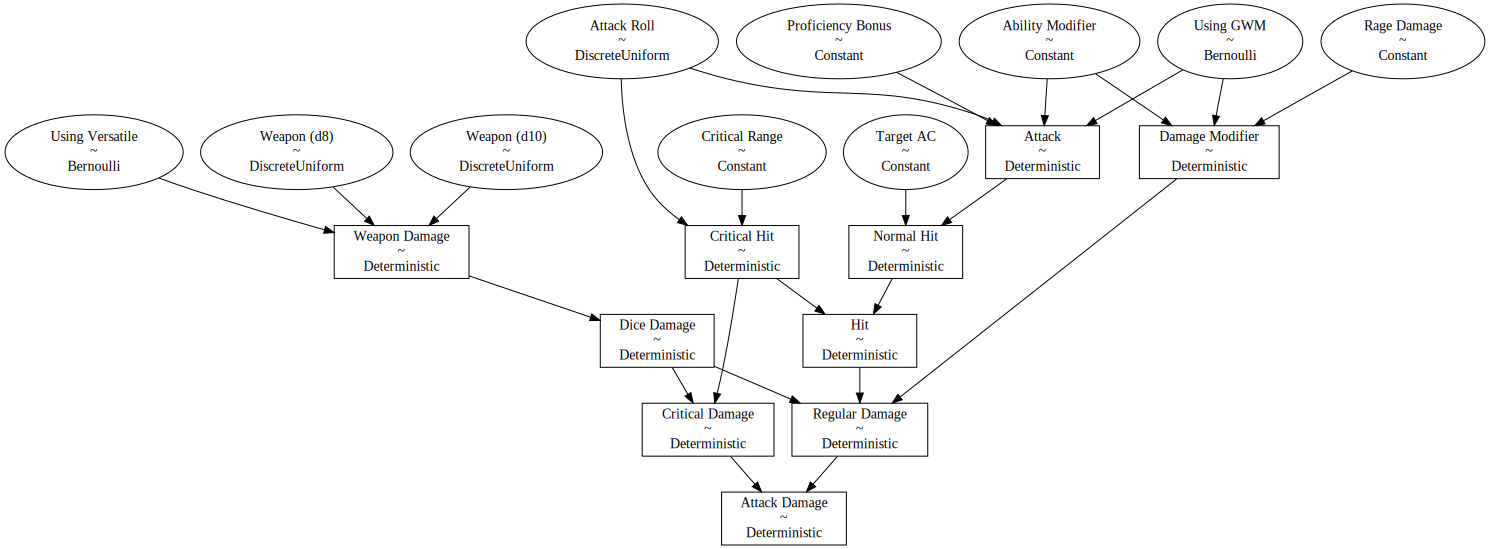

In [5]:
pm.model_to_graphviz(model)

# Damage Output

Finally, let's look at the predictive prior distribution of our generic
barbarian's damage output. The effects of doubling the damage dice (rather than
doubling the number of the dice) shows up in discrete histogram bins as we'd
expect. There's some discussion to be had about the distribution of the damage
rolls under the two critical strike rules, but we'll save that for another time.

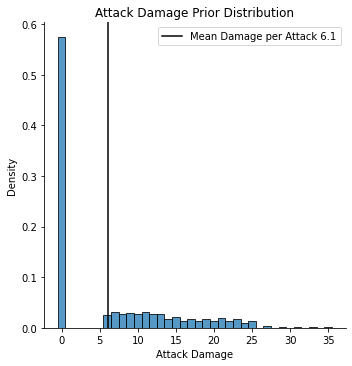

In [6]:
damage_fg = sns.displot(
    data=prior, x="Attack Damage", stat="density", discrete=True)

mean_damage = prior["Attack Damage"].mean()
damage_fg.ax.axvline(
    mean_damage,
    label=f"Mean Damage per Attack {mean_damage:.1f}", color="black")

damage_fg.ax.legend()
_ = damage_fg.ax.set_title("Attack Damage Prior Distribution")


# What would we do next?

If we include the damage variables from Ashton's chaos burst, then we can
obtain a posterior predictive distribution for them. To do so, we would need to
supply observations for other variables in the model. Some of these variables
are reported normally during gameplay such as whether an attack hit or was
a critical.

What variables do we really need in order to estimate the predictive posterior
for the damage dice? We are always given `Attack Damage`, `Hit`, and
`Critical Hit`. If we know whether or not our barbarian is always/never
`Using GWM` or if we know their `Damage Modifier` for each attack, then we can
deterministically compute `Dice Damage` without any simulation at all.
If we add `Chaos Burst` as defined above as a parent of `Dice Damage`, then
we're all set to begin our estimation process with the expectation of fairly
accurate results.


# Conclusion

If you're chomping at the bit to reverse engineer some new homebrew, and you're
keeping tabs on each attack event during the stream, then there's quite a bit
that we can estimate. Unless you're doing the analysis for fun, however, it's
probably better to either crowd source it or just tweet your question to Matt
directly.

If you enjoy unecessarily deep dives like these or if you'd like to see other
content, [checkout my blog](https://rob-hall.com/articles).